#Сегментация космических объектов 




## Загрузка данных

Для комфортной хагрузки данных добавьте ярлык папки Final_dataset (https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm) к себе на диск.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# !ls drive/MyDrive/Final_dataset

In [4]:
# images_path = 'drive/MyDrive/Final_dataset/images/'
# mask_path = 'drive/MyDrive/Final_dataset/mask/'
images_path = './dataset/images/'
mask_path = './dataset/mask/'

## Импортируем нужные библиотеки

In [5]:
# %%capture out
# !pip install albumentations torchmetrics pytorch_lightning -U
!pip3 install albumentations torchmetrics pytorch_lightning -U

In [6]:
!pip3 install segmentation_models_pytorch

In [7]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as T
from PIL import Image
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

In [8]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [9]:
class SattDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.imageset_path = images_path + split
        self.maskset_path = mask_path + split
        self.images_filenames = os.listdir(self.imageset_path) 
        self.mask_filenames = os.listdir(self.maskset_path)       
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        if len(self.images_filenames) <= idx:
            print('lengths', idx, len(self.images_filenames))
            return self.__getitem__(0)
        image_filename = self.images_filenames[idx]
        img_path = os.path.join(self.imageset_path, image_filename)
        image = cv2.imread(img_path)
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        msk_path = os.path.join(self.maskset_path, image_filename.replace(image_filename, image_filename.replace(".png", "")+"_mask.png"))
        mask = cv2.imread(msk_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [10]:
train_dataset = SattDataset()
val_dataset = SattDataset(split="val")

In [11]:
def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        transform = T.ToPILImage()
        img = transform(image)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

### Выбираем аугментации для обучения

Вы можете заменить аугментацию на ваш выбор

In [12]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = SattDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2()
    ]
)
val_dataset = SattDataset("val", transform=train_transform)

In [13]:
# raise ValueError("me")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


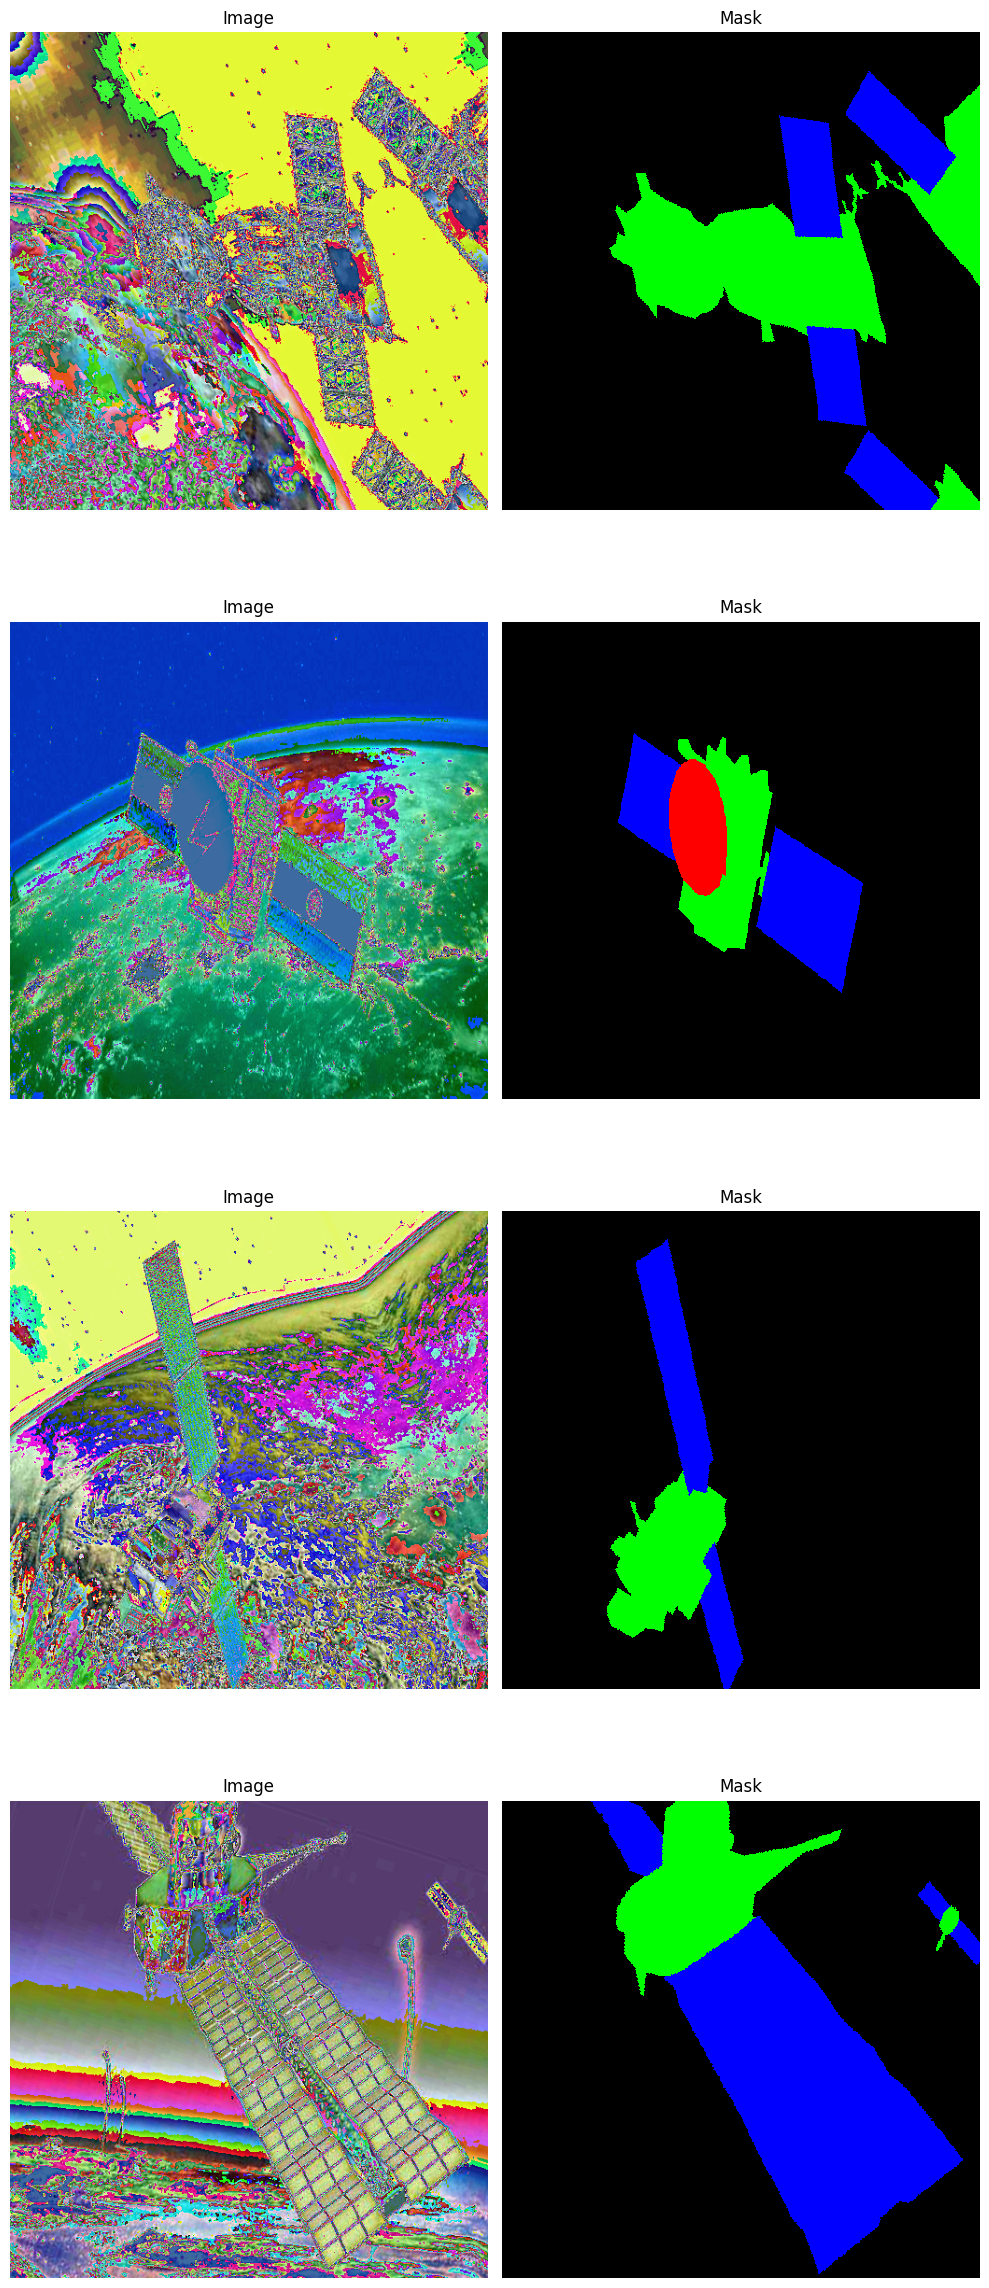

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


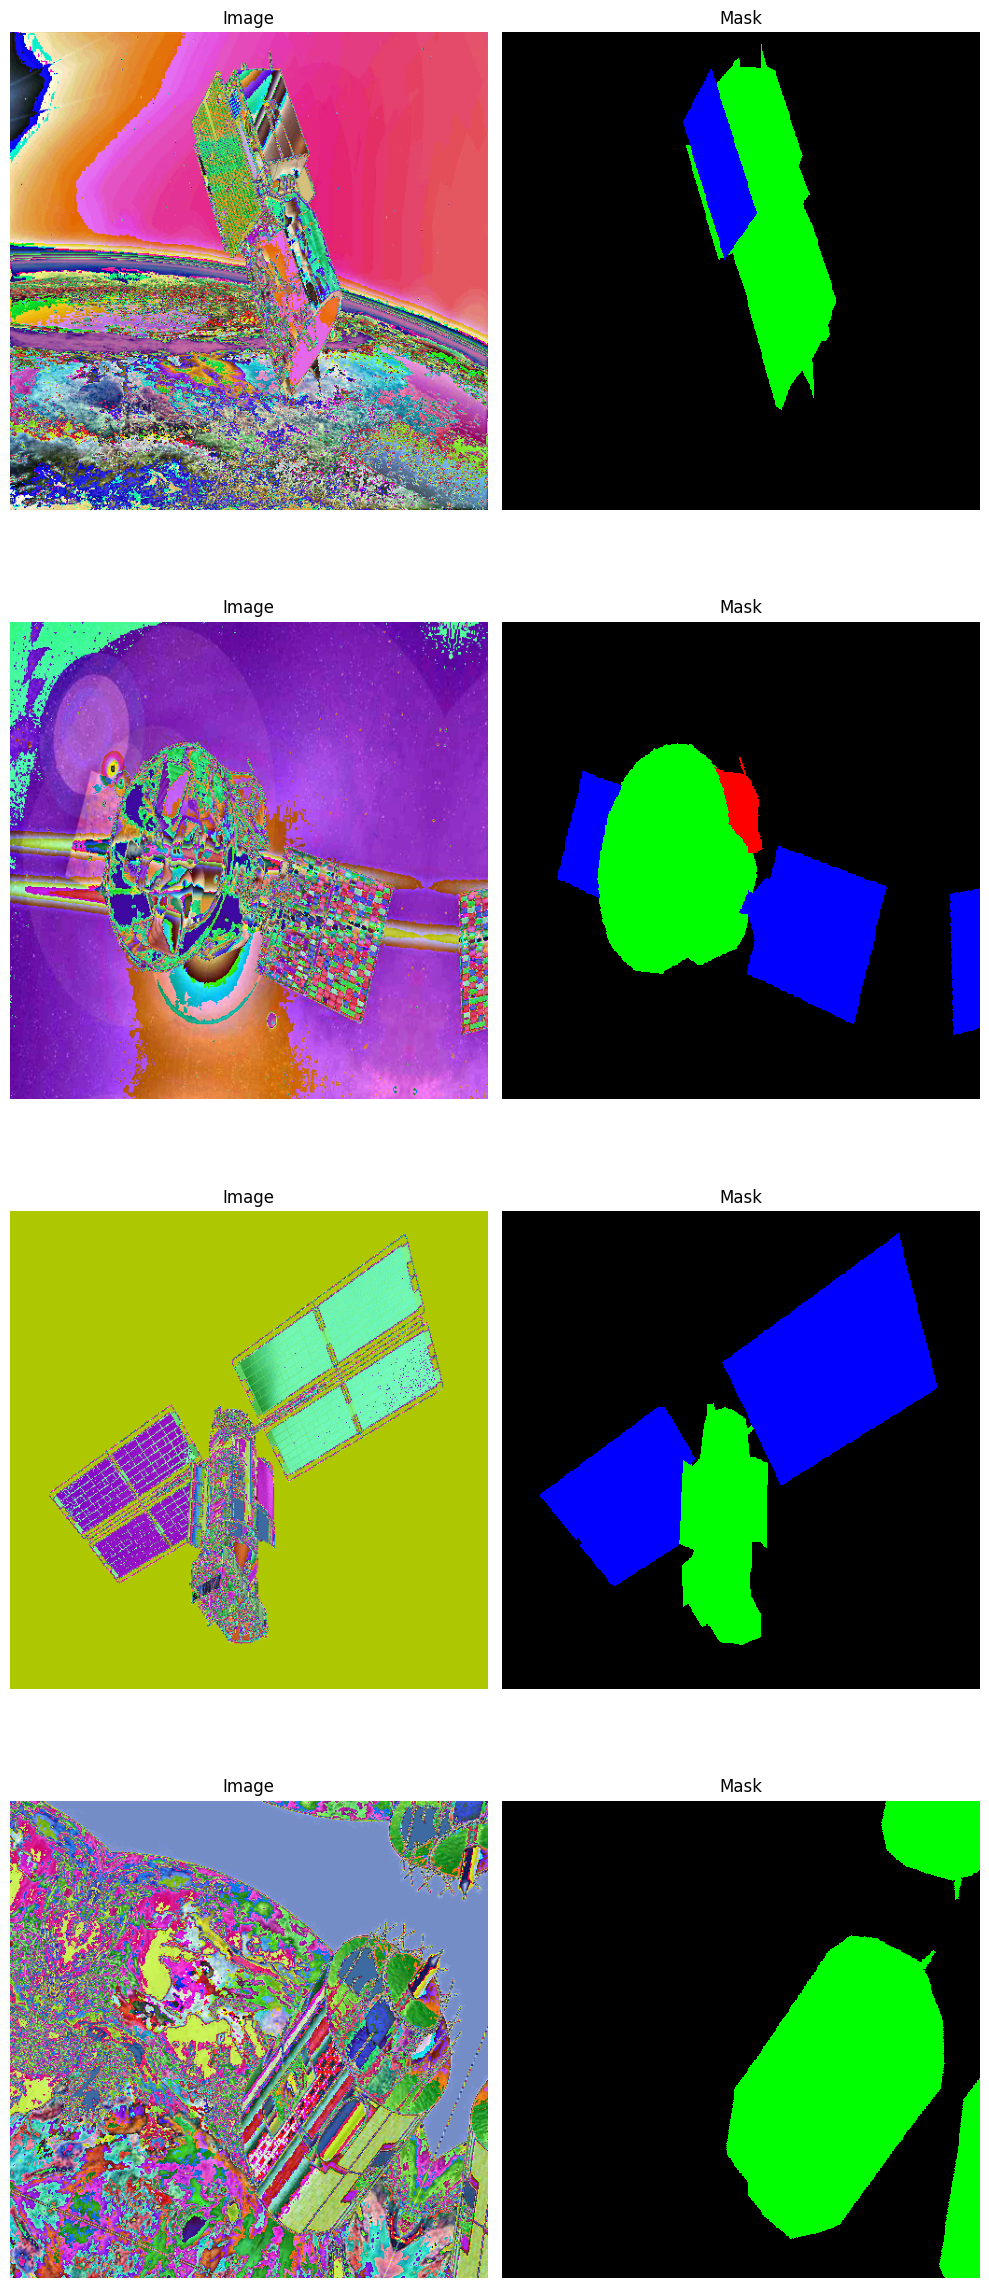

In [14]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

## Обучение модели

 
1.   Реализуйте выбранную вами модели instance segmentation
2.   Обучите модель
3.   Сравните разные метрики instance segmentation, включая mIoU



In [15]:
def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [16]:
import segmentation_models_pytorch as smp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

def filter_model_output(output,score_threshold):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      filtred_image[key] = image[key][image['scores'] >= score_threshold]
    filtred_output.append(filtred_image)
  return filtred_output

def get_boolean_mask(output):
  for index,pred in enumerate(output):
    output[index]['masks'] = pred['masks'] > 0.5
    output[index]['masks'] = output[index]['masks'].squeeze(1)
  return output

def calculate_iou(y_hat, y):
    # Convert the predicted and ground truth masks to binary tensors
    y_hat = (y_hat > 0).float()
    y = (y > 0).float()

    # Calculate the intersection and union of the masks
    intersection = torch.sum(y_hat * y)
    union = torch.sum(y_hat) + torch.sum(y) - intersection

    # Calculate the IoU score
    eps = 1e-8
    iou = (intersection / (union + eps)).mean()

    return iou

In [18]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()

        self.net = smp.Unet(
            encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=3,                      # model output channels (number of classes in your dataset)
        )
        self.batch_size = 1
        self.learning_rate = 1e-4
        # self.net = SomeModel(n_classes=1)
        # self.net = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, progress=False).to(device)
        # self.net.eval()

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img)

        mask = mask.squeeze(0)
        mask = mask.permute(2,0,1)
        # loss_val = self.criterion(out, mask)
        loss_val = self.criterion(out.squeeze(0), mask)
        # iou_score = IoU(out.float(), mask.long())
        iou_score = calculate_iou(out.squeeze(0), mask)
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          batch_size=self.batch_size, 
                          shuffle=True, prefetch_factor=2, num_workers=10)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=False)

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)

        mask = mask.squeeze(0)
        mask = mask.permute(2,0,1)
        # loss_val = self.criterion(out, mask)
        loss_val = self.criterion(out.squeeze(0), mask)
        # iou_score = IoU(out.float(), mask.long())
        iou_score = calculate_iou(out.squeeze(0), mask)
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)
        return loss_val

In [19]:
!nvidia-smi

print(torch.cuda.is_available())

Thu May 18 14:14:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    14W /  80W |    193MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
!pip3 install numpy==1.23.5

In [21]:
model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    devices=1, 
    accelerator='gpu',
    max_epochs=1,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    enable_progress_bar=True
    # progress_bar_refresh_rate=1,
)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | Unet             | 24.4 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.747    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

d:\ProgrammFiles\miniconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [ ]:
torch.save(model.state_dict(), "sat_maskrcnn_model.pt")

# from google.colab import files
# files.download("clutter_maskrcnn_model.pt")

In [ ]:
# pick one image from the test set
img, _ = val_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img])

In [ ]:
!pip3 list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac